Przygotowanie danych historycznych.
Główne funkcjonalności: \
1) czytywanie danych giełdowych z wielu plików CSV. \
2) Dodawanie informacji o tickerze (symbolu akcji). \
3) Filtrowanie danych na podstawie liczby rekordów i zakresu dat. \
4) Obliczanie zwrotu z inwestycji w oknach czasowych oraz ilustrowanie ich graficznie.
5) model predykcji zwrotów oparty na regresji liniowej- wyznaczenie parametrów metodą najmniejszych kwadratów

In [47]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from datetime import datetime
import os
from pyspark.sql.functions import to_date
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
input_dir = '/content/drive/My Drive/HSBC'

In [2]:
spark = SparkSession.builder \
    .appName("Stocks Data Analysis") \
    .getOrCreate()

In [3]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [4]:
# Schemat dla plików CSV
schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Close", DoubleType(), True)
])

In [17]:
def process_file(file_path, n_steps):
    df = spark.read.csv(file_path, schema=schema, header=False)

    df = df.withColumn("Symbol", F.input_file_name()) \
        .withColumn("Symbol", F.element_at(F.split(F.col("Symbol"), "\\."), 1))

    # Dodanie kolumny zliczającej liczbę wierszy dla każdego Symbol, bez filtrowania.
    df = df.withColumn('count', F.count("Symbol").over(Window.partitionBy('Symbol')))

    # Konwersja kolumny "Date" na format daty.
    df = df.withColumn("Date", F.to_date(F.to_timestamp(F.col('Date'), 'yy-MM-dd')))
    df = df.filter(F.col("Date") >= datetime(2019, 1, 2)) \
           .filter(F.col('Date') <= datetime(2024, 12, 30))

    # Funkcja do obliczania zwrotu (rolling window)
    window = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(1 - n_steps, 0)
    df = df.withColumn("return", \
                       (F.col("Close") - F.first("Close").over(window)) / F.first("Close").over(window))

    return df.orderBy("Symbol", "Date")

Liczba kroków jest równa 100 i jest to okno dwudziestu tygodni (giełda nie jest otwarta w weekedy). Obliczanie zwrotu z inwestycji dla każdego symbolu akcji w oknie czasowym o długości n_steps, a wynik jest dodawany do final_df. Teraz dane mogą być przetwarzane dalej lub eksportowane. Exportujemy dane do PandasDataFrame

In [22]:
# Obliczany jest zwrot z inwestycji (return) jako procentowa zmiana wartości w oknie czasowym o długości n_steps dni.
# Używane są okna czasowe (Window), które grupują dane według Symbol i sortują według daty.
n_steps = 100

all_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')]

# Przetwarzanie każdego pliku jako osobny DataFrame i przechowywanie w słowniku
dataframes = {}
for file_path in all_files:
    # Klucz w słowniku to nazwa pliku bez rozszerzenia
    file_name = os.path.basename(file_path).split('.')[0]
    dataframes[file_name] = process_file(file_path, n_steps)

# Przykład dostępu do poszczególnych DataFrame'ów
for symbol, df in dataframes.items():
    print(f"Symbol: {symbol}")
    df.show(5)

Symbol: S&P_500_historical_data
+----------+-----------------+--------------------+-----+--------------------+
|      Date|            Close|              Symbol|count|              return|
+----------+-----------------+--------------------+-----+--------------------+
|2019-01-02|  2476.9599609375|file:///content/d...| 1512|                 0.0|
|2019-01-03|   2491.919921875|file:///content/d...| 1512|0.006039645845481423|
|2019-01-04|   2474.330078125|file:///content/d...| 1512|-0.00106173812010...|
|2019-01-07|2535.610107421875|file:///content/d...| 1512|0.023678277973527118|
|2019-01-08|2568.110107421875|file:///content/d...| 1512| 0.03679920060148076|
+----------+-----------------+--------------------+-----+--------------------+
only showing top 5 rows

Symbol: Dow_Jones_historical_data
+----------+---------------+--------------------+-----+--------------------+
|      Date|          Close|              Symbol|count|              return|
+----------+---------------+----------------

In [23]:
symbol = "S&P_500_historical_data"
if symbol in dataframes:
    final_df = dataframes[symbol]

    pandas_df = final_df.toPandas()

    # Dodanie nowej kolumny 'stock_returns' na podstawie kolumny 'Close'
    pandas_df = pandas_df.assign(stock_returns=pandas_df['Close'])

    print(pandas_df.head())

         Date        Close                                             Symbol  \
0  2019-01-02  2476.959961  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
1  2019-01-03  2491.919922  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
2  2019-01-04  2474.330078  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
3  2019-01-07  2535.610107  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
4  2019-01-08  2568.110107  file:///content/drive/My%20Drive/HSBC/S&P_500_...   

   count    return  stock_returns  
0   1512  0.000000    2476.959961  
1   1512  0.006040    2491.919922  
2   1512 -0.001062    2474.330078  
3   1512  0.023678    2535.610107  
4   1512  0.036799    2568.110107  


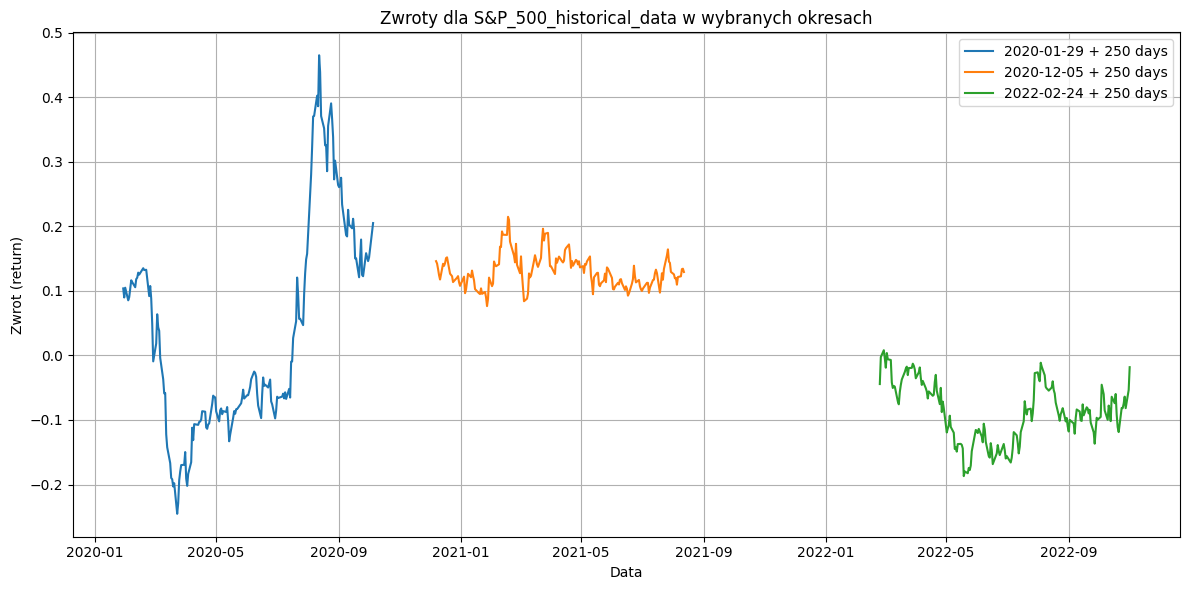

In [25]:
symbol = "S&P_500_historical_data"
if symbol in dataframes:
    final_df = dataframes[symbol]
    pandas_df = final_df.toPandas()

    pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])

    periods = [
        ("2020-01-29", 250),
        ("2020-12-05", 250),
        ("2022-02-24", 250)
    ]

    plt.figure(figsize=(12, 6))
    for start_date, days in periods:
        start_date = pd.to_datetime(start_date)
        end_date = start_date + pd.Timedelta(days=days)

        # Filtrowanie danych w tym przedziale czasowym
        filtered_data = pandas_df[(pandas_df['Date'] >= start_date) & (pandas_df['Date'] <= end_date)]

        plt.plot(
            filtered_data['Date'],
            filtered_data['return'],
            label=f"{start_date.date()} + {days} days"
        )

    plt.title(f"Zwroty dla {symbol} w wybranych okresach")
    plt.xlabel("Data")
    plt.ylabel("Zwrot (return)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

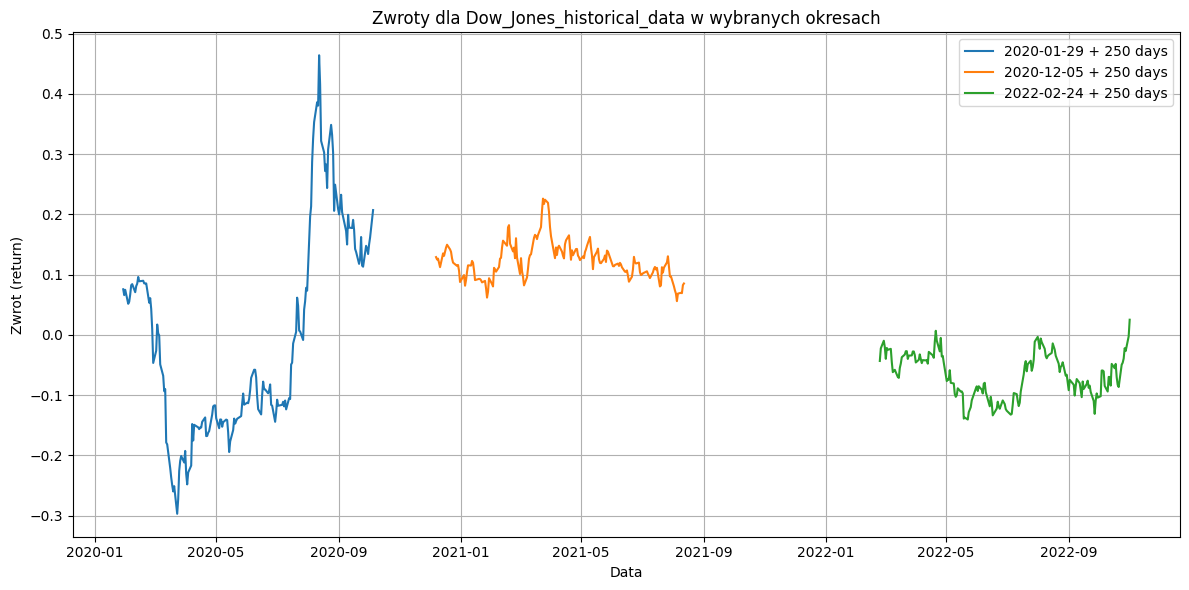

In [26]:
symbol = "Dow_Jones_historical_data"
if symbol in dataframes:
    final_df = dataframes[symbol]
    pandas_df = final_df.toPandas()

    pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])

    periods = [
        ("2020-01-29", 250),
        ("2020-12-05", 250),
        ("2022-02-24", 250)
    ]

    plt.figure(figsize=(12, 6))
    for start_date, days in periods:
        start_date = pd.to_datetime(start_date)
        end_date = start_date + pd.Timedelta(days=days)

        # Filtrowanie danych w tym przedziale czasowym
        filtered_data = pandas_df[(pandas_df['Date'] >= start_date) & (pandas_df['Date'] <= end_date)]

        plt.plot(
            filtered_data['Date'],
            filtered_data['return'],
            label=f"{start_date.date()} + {days} days"
        )

    # Dodanie etykiet i legendy
    plt.title(f"Zwroty dla {symbol} w wybranych okresach")
    plt.xlabel("Data")
    plt.ylabel("Zwrot (return)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

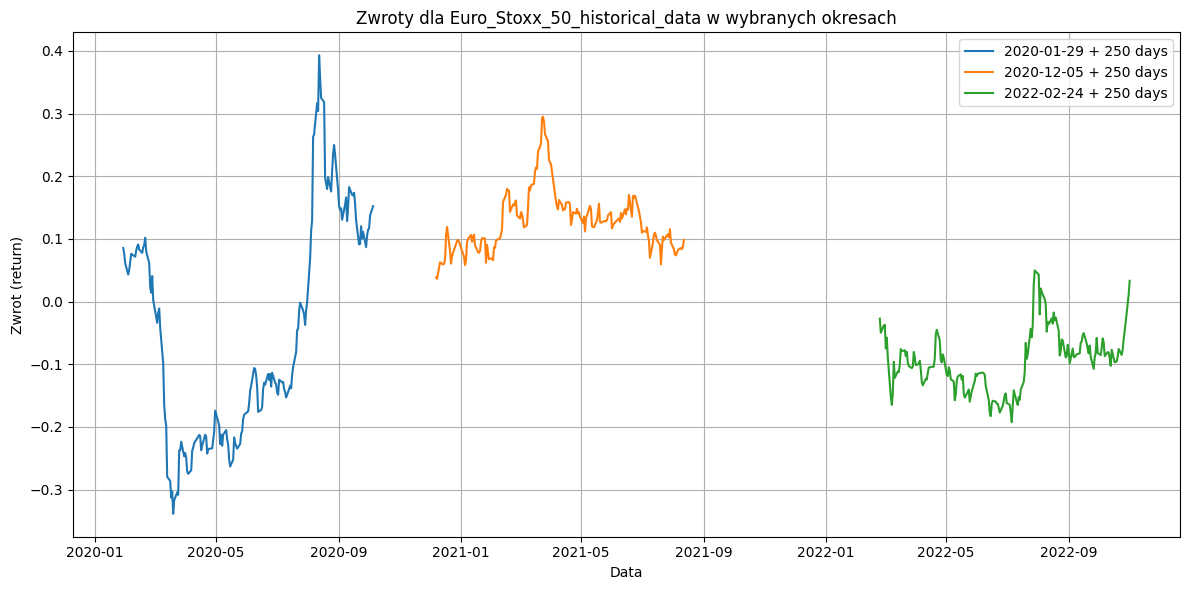

In [27]:
symbol = "Euro_Stoxx_50_historical_data"
if symbol in dataframes:
    final_df = dataframes[symbol]
    pandas_df = final_df.toPandas()

    pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])

    periods = [
        ("2020-01-29", 250),
        ("2020-12-05", 250),
        ("2022-02-24", 250)
    ]

    plt.figure(figsize=(12, 6))
    for start_date, days in periods:
        start_date = pd.to_datetime(start_date)
        end_date = start_date + pd.Timedelta(days=days)

        # Filtrowanie danych w tym przedziale czasowym
        filtered_data = pandas_df[(pandas_df['Date'] >= start_date) & (pandas_df['Date'] <= end_date)]

        plt.plot(
            filtered_data['Date'],
            filtered_data['return'],
            label=f"{start_date.date()} + {days} days"
        )

    plt.title(f"Zwroty dla {symbol} w wybranych okresach")
    plt.xlabel("Data")
    plt.ylabel("Zwrot (return)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

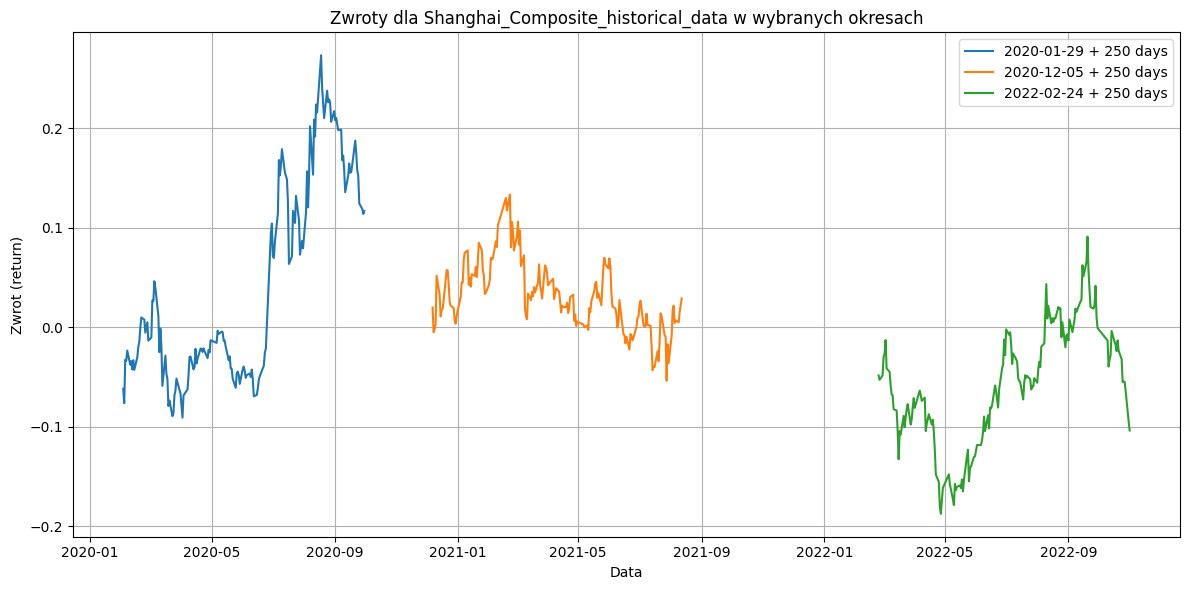

In [28]:
symbol = "Shanghai_Composite_historical_data"
if symbol in dataframes:
    final_df = dataframes[symbol]
    pandas_df = final_df.toPandas()

    pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])

    periods = [
        ("2020-01-29", 250),
        ("2020-12-05", 250),
        ("2022-02-24", 250)
    ]

    plt.figure(figsize=(12, 6))
    for start_date, days in periods:
        start_date = pd.to_datetime(start_date)
        end_date = start_date + pd.Timedelta(days=days)

        # Filtrowanie danych w tym przedziale czasowym
        filtered_data = pandas_df[(pandas_df['Date'] >= start_date) & (pandas_df['Date'] <= end_date)]

        plt.plot(
            filtered_data['Date'],
            filtered_data['return'],
            label=f"{start_date.date()} + {days} days"
        )

    plt.title(f"Zwroty dla {symbol} w wybranych okresach")
    plt.xlabel("Data")
    plt.ylabel("Zwrot (return)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Metoda najmniejszych kwadratów z moduły scikit-learn: Wcześniej usuwania Na

In [34]:
from sklearn.linear_model import LinearRegression
import numpy as np
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

In [45]:
pandas_df.replace([np.inf, -np.inf], np.nan, inplace=True)
pandas_df = pandas_df.dropna(subset=['return'])
# Sprawdzanie, czy kolumna 'rolling_return' istnieje
if 'rolling_return' not in pandas_df.columns:
    feature_columns = ['Close', 'count', 'return']

In [43]:
@pandas_udf(
    StructType(
        [StructField("Symbol", StringType(), True)] +
        [StructField(f"coef_{feature}", DoubleType(), True) for feature in feature_columns]
    ),
    PandasUDFType.GROUPED_MAP
)
def find_ols_coef_udf(pdf: pd.DataFrame) -> pd.DataFrame:
    y = pdf['return']

    X = pdf[feature_columns]

    regr = LinearRegression()

    regr.fit(X, y)

    coef_list = [pdf['Symbol'].iloc[0]] + list(regr.coef_)

    return pd.DataFrame([coef_list], columns=['Symbol'] + [f"coef_{feature}" for feature in feature_columns])

coef_per_stock_df = df.groupby('Symbol').apply(find_ols_coef_udf)

coef_per_stock_df.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+--------------------+--------------------+----------+------------------+
|              Symbol|          coef_Close|coef_count|       coef_return|
+--------------------+--------------------+----------+------------------+
|file:///content/d...|8.398768480103547...|       0.0|0.9999999999999994|
+--------------------+--------------------+----------+------------------+

